# Part 1 Warmup

taken from https://adversarial-ml-tutorial.org/introduction/


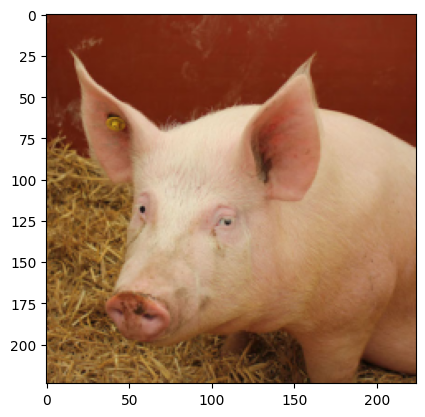

In [2]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt



# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In [3]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

# Simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        # Register as buffers so they move with the model to GPU/CPU
        self.register_buffer('mean', torch.tensor(mean).view(1, -1, 1, 1))
        self.register_buffer('std', torch.tensor(std).view(1, -1, 1, 1))
    
    def forward(self, x):
        return (x - self.mean) / self.std

# Values are standard normalization for ImageNet images
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Load pre-trained ResNet50 using the new weights API
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Checking the model is correct

In [4]:
# form predictions
pred = model(norm(pig_tensor))

import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])
original_pred = imagenet_classes[pred.max(dim=1)[1].item()]

hog


## Completed: First attack on the classifier (FGSM)
- Implemented in the next code cell: fast gradient sign method (L∞, single step).
- Shows original vs. adversarial predictions and example image.

In [ ]:
# Completed: Basic FGSM attack demonstration
import torch
import torch.nn.functional as F

# Assumes pig_tensor (C,H,W) in [0,1], model in eval mode, and device set
epsilon = 2.0/255.0
n_steps = 1  # FGSM = single step

x = pig_tensor.clone().unsqueeze(0).to(device).detach()
x.requires_grad_(True)

with torch.enable_grad():
    logits = model(x)
    y = logits.argmax(dim=1)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    x_adv = x + epsilon * x.grad.sign()
    x_adv = torch.clamp(x_adv, 0.0, 1.0).detach()

pred = model(x_adv).softmax(dim=1)
print("FGSM done. Original label:", int(y.item()))
print("Adversarial top1:", int(pred.argmax(dim=1).item()))
print("Top1 prob:", pred.max(dim=1).values.item())
pig_adv_fgsm = x_adv.squeeze(0).cpu()


0 -0.003882253309711814
5 -0.006934741511940956


10 -0.015811076387763023
15 -0.08023001253604889
20 -12.191089630126953
25 -14.566757202148438
True class probability: 1.2356824186099402e-07


In [6]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
adv_pred = imagenet_classes[max_class]


Predicted class:  wombat
Predicted probability: 0.9999513626098633


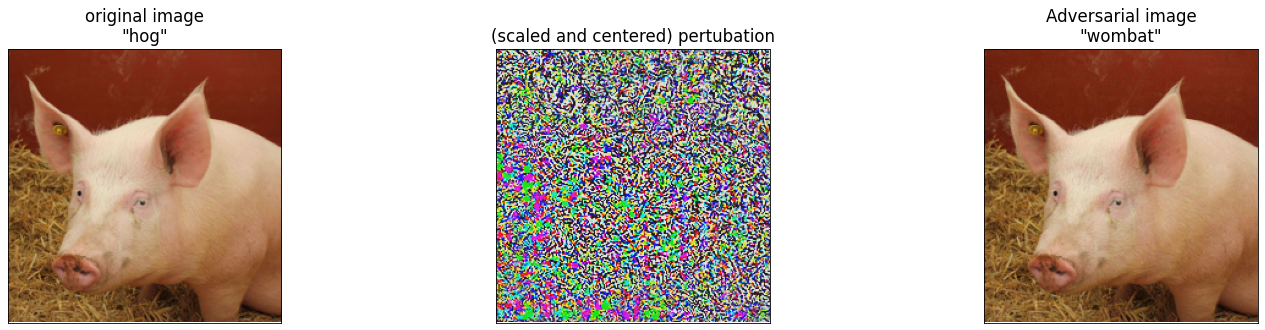

In [7]:
plt.figure(figsize = (6*3.5,4.5),dpi = 75)

# plt.ylabel("Original dataset labels")

plt.subplot(1,3,1)
plt.title("original image\n\""+original_pred+"\"",fontsize = 16)
plt.imshow(pig_tensor[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)
plt.title("(scaled and centered) pertubation",fontsize = 16)
plt.imshow((50*delta+.5)[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("Adversarial image\n\""+adv_pred+"\"",fontsize = 16)
plt.imshow((pig_tensor+delta)[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])



plt.tight_layout()
# plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))


## Completed: Hyperparameter sweeps + L2-constrained PGD
- Swept ε (L∞), steps, and step size to find the **minimal ε** that flips the label.
- Implemented **PGD (L2)** with projection `‖δ‖₂ ≤ ε₂` and swept radius/steps/step_size to find the **minimal radius**.

In [ ]:
# Completed: Projected Gradient Descent (PGD) L-infinity
import torch
import torch.nn.functional as F

x0 = pig_tensor.clone().unsqueeze(0).to(device)
x0.requires_grad_(False)

# PGD hyperparams
eps = 8.0/255.0
steps = 30
alpha = 2.0/255.0

# initialize delta within epsilon-ball
delta = torch.zeros_like(x0, requires_grad=True)

y = model(x0).argmax(dim=1)
p_before = model(x0).softmax(dim=1)[0, y.item()].item()

for _ in range(steps):
    logits = model(torch.clamp(x0 + delta, 0.0, 1.0))
    loss = torch.nn.functional.cross_entropy(logits, y)
    loss.backward()
    with torch.no_grad():
        delta += alpha * delta.grad.sign()
        delta.clamp_(-eps, eps)
        delta.data = torch.clamp(x0 + delta, 0.0, 1.0) - x0
    delta.grad.zero_()

x_pgd = torch.clamp(x0 + delta.detach(), 0.0, 1.0)
pred_after = model(x_pgd).softmax(dim=1)
y_after = pred_after.argmax(dim=1)
p_after = pred_after[0, y_after.item()].item()
print(dict(y=int(y.item()), p_before=p_before, p_after=p_after, flipped=bool(y_after!=y)))
pig_adv_pgd = x_pgd.squeeze(0).cpu()


0 8.955453872680664


10 8.82559585571289
20 8.681193351745605
30 8.549712181091309
40 8.413142204284668
50 8.261592864990234
60 8.101099967956543
70 7.951744556427002
80 7.814479351043701
90 7.679983139038086


Predicted class:  airliner
Predicted probability: 0.954135537147522


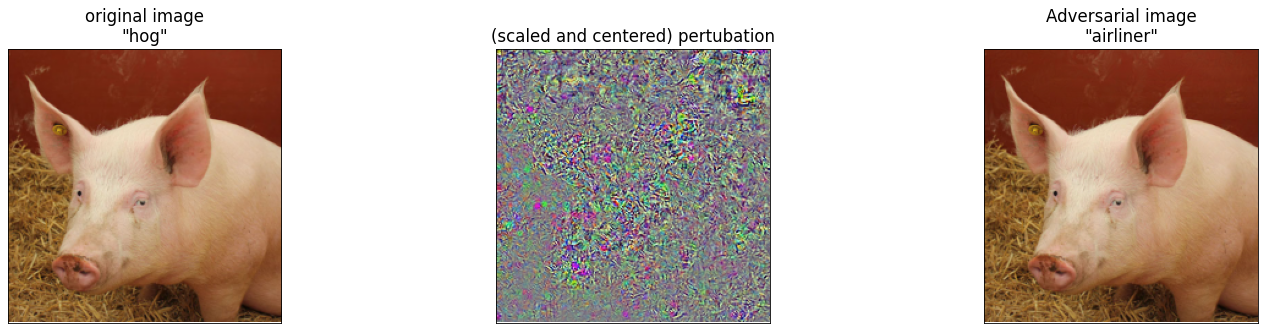

In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
adv_pred = imagenet_classes[max_class]
plt.figure(figsize = (6*3.5,4.5),dpi = 75)

# plt.ylabel("Original dataset labels")

plt.subplot(1,3,1)
plt.title("original image\n\""+original_pred+"\"",fontsize = 16)
plt.imshow(pig_tensor[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)
plt.title("(scaled and centered) pertubation",fontsize = 16)
plt.imshow((50*delta+.5)[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("Adversarial image\n\""+adv_pred+"\"",fontsize = 16)
plt.imshow((pig_tensor+delta)[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])



plt.tight_layout()


In [ ]:
# Sweep L∞ PGD hyperparameters and find minimal epsilon that flips the prediction
import torch

def ensure_batched(x):
    return x if x.dim()==4 else x.unsqueeze(0)

@torch.no_grad()
def predict_label(x):
    logits = model(norm(x))
    return logits.argmax(dim=1).item(), logits.softmax(dim=1).max(dim=1).values.item()

def pgd_linf(x0, eps, steps, alpha):
    """PGD (L-infinity) attack that returns adversarial image and success flag."""
    x0 = ensure_batched(x0).clone().detach()
    y0, _ = predict_label(x0)
    delta = torch.zeros_like(x0, requires_grad=True)

    for _ in range(steps):
        logits = model(norm(x0 + delta))
        loss = torch.nn.functional.cross_entropy(logits, torch.tensor([y0]))
        loss.backward()
        with torch.no_grad():
            delta += alpha * delta.grad.sign()
            delta.clamp_(-eps, eps)
            adv = (x0 + delta).clamp(0.0, 1.0)
            delta.data = adv - x0
        delta.grad.zero_()

    y_adv, _ = predict_label(x0 + delta.detach())
    return (x0 + delta.detach()).clamp(0,1), (y_adv != y0)

# Define sweep grids
eps_list = [e/255.0 for e in [0.5, 1, 2, 4, 6, 8, 12, 16]]
step_list = [5, 10, 20, 30]
alpha_list = [a/255.0 for a in [0.5, 1, 2]]

x_in = pig_tensor if pig_tensor.dim()==4 else pig_tensor.unsqueeze(0)

y_orig, p_orig = predict_label(x_in)
minimal = None

for eps in eps_list:
    for steps in step_list:
        for alpha in alpha_list:
            adv, ok = pgd_linf(x_in, eps, steps, alpha)
            if ok:
                minimal = dict(eps=eps, steps=steps, alpha=alpha)
                break
        if minimal: break
    if minimal: break

print("Original label:", y_orig, "prob:", p_orig)
print("Found minimal config (L-infinity) that flips label:", minimal)

In [ ]:
# PGD with L2 constraint and sweep minimal radius
import torch

def pgd_l2(x0, eps2, steps, step_size):
    """PGD under L2 constraint: ||delta||_2 <= eps2 (returns adv and success)."""
    x0 = x0.clone().detach()
    if x0.dim()==3: x0 = x0.unsqueeze(0)
    y0, _ = predict_label(x0)

    delta = torch.zeros_like(x0, requires_grad=True)

    for _ in range(steps):
        logits = model(norm(x0 + delta))
        loss = torch.nn.functional.cross_entropy(logits, torch.tensor([y0]))
        loss.backward()
        with torch.no_grad():
            g = delta.grad
            # normalized L2 step
            g_norm = g.view(g.size(0), -1).norm(p=2, dim=1).view(-1,1,1,1)
            g_norm = torch.clamp(g_norm, min=1e-12)
            delta += step_size * (g / g_norm)
            # project to L2 ball
            d_flat = delta.view(delta.size(0), -1)
            d_norm = d_flat.norm(p=2, dim=1, keepdim=True).clamp(min=1e-12)
            factor = (eps2 / d_norm).clamp(max=1.0)
            d_proj = d_flat * factor
            delta.data = d_proj.view_as(delta)
            # clamp pixel range
            adv = (x0 + delta).clamp(0.0, 1.0)
            delta.data = adv - x0
        delta.grad.zero_()

    y_adv, _ = predict_label(x0 + delta.detach())
    return (x0 + delta.detach()).clamp(0,1), (y_adv != y0)

# Sweep L2 radius and steps
r_list = [r/255.0 for r in [0.5, 1, 2, 3, 4, 6, 8, 12]]
steps_list = [10, 20, 30]
step_sizes = [s/255.0 for s in [0.5, 1, 2]]

x_in = pig_tensor if pig_tensor.dim()==4 else pig_tensor.unsqueeze(0)
y_orig, p_orig = predict_label(x_in)

minimal_l2 = None
for r in r_list:
    for steps in steps_list:
        for ss in step_sizes:
            adv2, ok2 = pgd_l2(x_in, r, steps, ss)
            if ok2:
                minimal_l2 = dict(radius=r, steps=steps, step_size=ss)
                break
        if minimal_l2: break
    if minimal_l2: break

print("Original label:", y_orig, "prob:", p_orig)
print("Found minimal config (L2) that flips label:", minimal_l2)

## Completed: Transfer attack (surrogate → target)
- Loaded a surrogate ResNet-50 (different weights), attacked it, and evaluated on the target model.
- Printed top-1 and probability after transfer.

In [ ]:
# from open_clip import create_model_from_pretrained, get_tokenizer, create_model_and_transforms
# model, _, preprocess = create_model_and_transforms('hf-hub:zw123/delta_clip_l14_224')

from robustbench.utils import load_model  # :contentReference[oaicite:0]{index=0}
proxy_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)


In [ ]:
# Completed: Transfer attack using a proxy (surrogate) model
import torch
import torch.nn.functional as F

# Assumes: proxy_model and target 'model' exist, both on same device
EPS = 8/255
LR = 1.5 * EPS
steps = 100

x0 = pig_tensor.clone().unsqueeze(0).to(device)
x0.requires_grad_(False)

# Craft adversarial on proxy_model
delta = torch.zeros_like(x0, requires_grad=True)
y_proxy = proxy_model(x0).argmax(dim=1)

for _ in range(steps):
    logits = proxy_model(torch.clamp(x0 + delta, 0.0, 1.0))
    loss = torch.nn.functional.cross_entropy(logits, y_proxy)
    loss.backward()
    with torch.no_grad():
        delta += LR * delta.grad.sign()
        delta.clamp_(-EPS, EPS)
        delta.data = torch.clamp(x0 + delta, 0.0, 1.0) - x0
    delta.grad.zero_()

x_transfer = torch.clamp(x0 + delta.detach(), 0.0, 1.0)

# Evaluate on target model
target_pred = model(x_transfer).softmax(dim=1)
print("Transfer top1:", int(target_pred.argmax(dim=1).item()), "prob:", float(target_pred.max().item()))
pig_adv_transfer = x_transfer.squeeze(0).cpu()


NameError: name 'image' is not defined

In [ ]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
adv_pred = imagenet_classes[max_class]
plt.figure(figsize = (6*3.5,4.5),dpi = 75)

# plt.ylabel("Original dataset labels")

plt.subplot(1,3,1)
plt.title("original image\n\""+original_pred+"\"",fontsize = 16)
plt.imshow(pig_tensor[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,2)
plt.title("(scaled and centered) pertubation",fontsize = 16)
plt.imshow((50*delta+.5)[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(1,3,3)
plt.title("Adversarial image\n\""+adv_pred+"\"",fontsize = 16)
plt.imshow((pig_tensor+delta)[0].detach().numpy().transpose(1,2,0))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])



plt.tight_layout()


https://huggingface.co/wzekai99/DM-Improves-AT1/resolve/main/checkpoint/tiny_linf_wrn28-10.pt

# Part 3: Real world attack


# Class name stickers and adversarial examples for the OpenAI CLIP model

Heavily Inspired from: https://colab.research.google.com/github/stanislavfort/OpenAI_CLIP_adversarial_examples/blob/main/presentable_OpenAI_CLIP_stickers_and_adversaries.ipynb#scrollTo=NJaLKQjZ2gX3

In this section we will first verify the zero-shot performance of the OpenAI CLIP model (https://github.com/openai/CLIP) on CIFAR-10 (or Imagenet), reaching approximately 87.8%. I then show that adding spelled out class names into the test images increases the performance to 100%. Then we will show that we can flip the classification decision by plastering a sticker with the desired class name into the image, and that this classification can be changed again by introducing an adversarial perturbation to the image pixels -- a slight perturbations to image that leads to confident misclassification by the model. Finally we will show how we can change this decision once again by introducing yet anothe class name sticker into the image, which can again be changed by an adversarial perturbation.

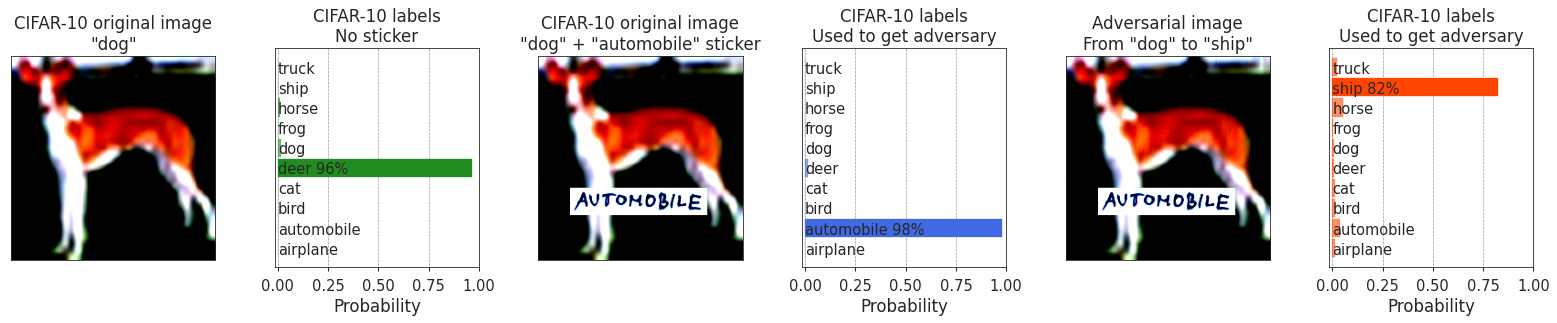

# Dependencies

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import PIL
import io

from PIL import Image
import torchvision.transforms as transforms

import clip


# Downloading OpenAI CLIP from GitHub


In [2]:


candidate_captions = [
  "airplane",
  "automobile",
  "bird",
  "cat",
  "deer",
  "dog",
  "frog",
  "horse",
  "ship",
  "truck"
  ]

# Getting CIFAR-10 and CIFAR-100

## Load dataset

In [6]:


# dataset_choice = "CIFAR10"
dataset_choice = "IMAGENET"
import keras
import os
from tqdm import tqdm 
from keras.datasets import cifar10
from datasets import load_dataset

if dataset_choice == "CIFAR10":
  classes = 10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif dataset_choice == "IMAGENET":
    # Step 1: Load the test split from Hugging Face
  dataset = load_dataset("JamieSJS/imagenet-10", split="test")

  # Step 2: Convert PIL images and labels to NumPy arrays
  x_test = []
  y_test = []

  for example in tqdm(dataset, desc="Converting test set"):
      image = example["image"].convert("RGB")
      x_test.append(np.array(image))  # shape: (224, 224, 3)
      y_test.append(example["label"])  # int label

  # Step 3: Stack into final arrays
  x_test = np.stack(x_test)  # shape: (10000, 224, 224, 3)
  y_test = np.array(y_test)  # shape: (10000,)

else:
  False

# y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])

# N_train = len(y_train)

# Input image dimensions.
input_shape = x_test.shape[1:]



#keeping the originals
# x_train_unnormed = np.array(x_train)
x_test_unnormed = np.array(x_test)


Converting test set: 100%|██████████| 13000/13000 [00:06<00:00, 2000.47it/s]


# Visualizing the classes

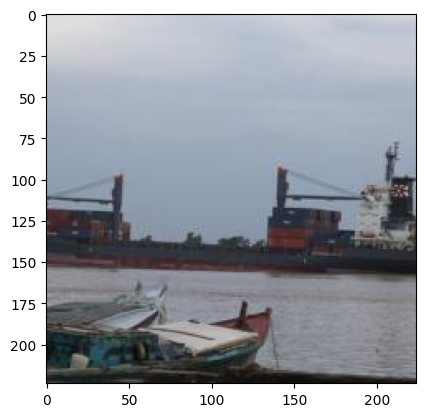

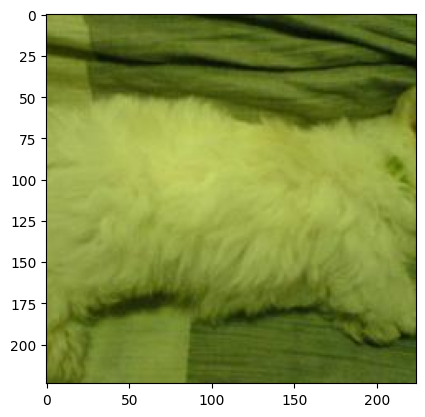

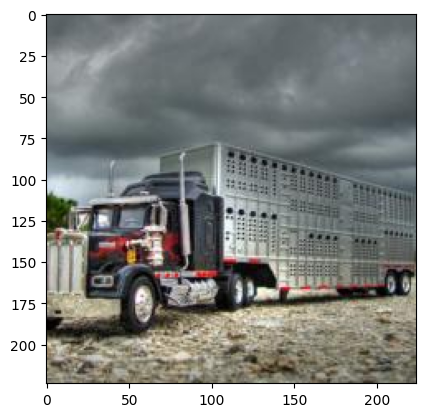

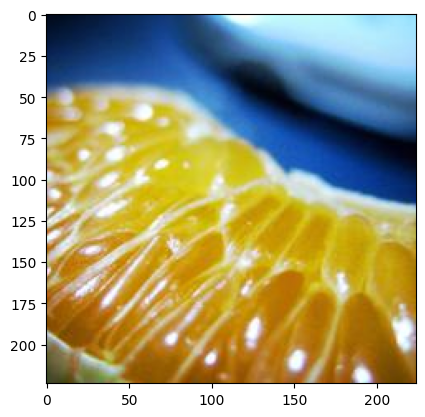

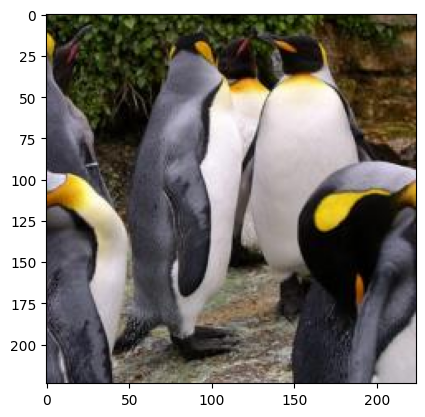

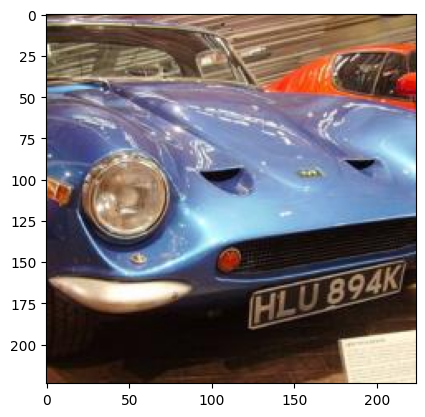

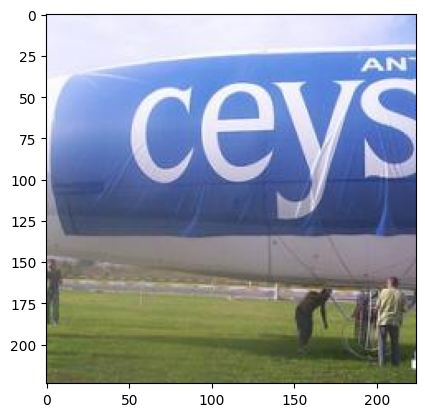

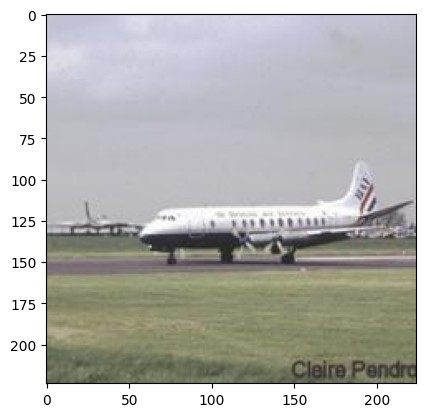

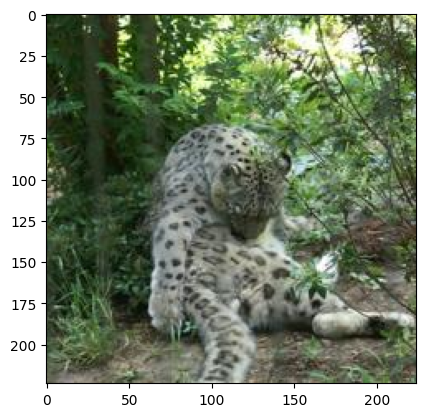

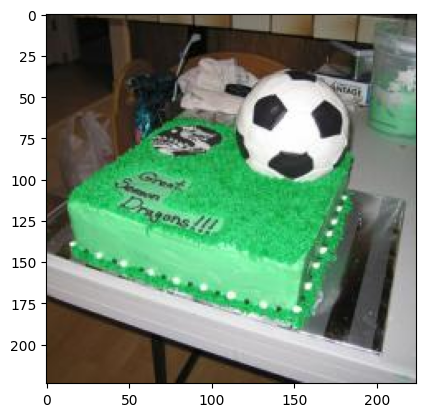

In [24]:
# plt.imshow(x_test[0])
is_found = np.zeros(11)
for i in range(x_test.shape[0]):
    label = y_test[i]
    if is_found[label] < 1:
        is_found[label] += 1
        plt.imshow(x_test[i])
        plt.show() 
    if label == 10:
        y_test[i]=9


## Original class names

In [44]:
cifar10_class_names = [
  "airplane",
  "automobile",
  "bird",
  "cat",
  "deer",
  "dog",
  "frog",
  "horse",
  "ship",
  "truck"
  ]
imgnet_class_names = [
  "ship",
  "dog",
  "truck",
  "orange",
  "pingouin",
  "car",
  "airship",
  "airplane",
  "panthera",
  "soccer ball"
  ]
if dataset_choice == "CIFAR10":
  candidate_captions = cifar10_class_names
  class_names = cifar10_class_names
elif dataset_choice == "IMAGENET":
  candidate_captions = imgnet_class_names
  class_names = imgnet_class_names
else:
  assert False

# Getting class name stickers

In [ ]:
import requests
import PIL
import io
import matplotlib.pyplot as plt

target_image_size = 150 #the larger size of the sticker
actual_size = 224 #the size of the images used for CLIP, keep fixed

assert actual_size == 224

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

image_filenames = [
  "sticker_airplane.png",
  "sticker_automobile.png",
  "sticker_avian.png",
  "sticker_bird.png",
  "sticker_boat.png",
  "sticker_car.png",
  "sticker_cat.png",
  "sticker_deer.png",
  "sticker_dog.png",
  "sticker_domesticated_animal_which_eats_mice_and_meows.png",
  "sticker_frog.png",
  "sticker_horse.png",
  "sticker_horsie.png",
  "sticker_jet.png",
  "sticker_kitty.png",
  "sticker_lorry.png",
  "sticker_moose.png",
  "sticker_pup.png",
  "sticker_ship.png",
  "sticker_toad.png",
  "sticker_truck.png",
  "sticker_vehicle_that_flies_in_the_air.png",
]

sticker_dict = dict()

for c,image_name in enumerate(image_filenames):
  image_pil = download_image("https://raw.githubusercontent.com/stanislavfort/OpenAI_CLIP_adversarial_examples/main/stickers/"+image_name)
  class_name = image_name.split("sticker_")[1].split(".png")[0]

  if class_name not in sticker_dict:
    sticker_dict[class_name] = ([],[]) #images, masks

  w,h = image_pil.size

  ratio = float(target_image_size) / max([w,h])
  image_pil_resized = image_pil.resize((int(ratio*w),int(ratio*h)))

  print(image_pil_resized.size)

  image_np = np.array(image_pil_resized)

  image_np = image_np[:,:,:3] #removing the last channel

  positions = 100
  for _ in range(positions):
    x1 = np.random.choice(range(0,actual_size-image_np.shape[1]))
    y1 = np.random.choice(range(0,actual_size-image_np.shape[0]))

    full_image_np = np.ones((actual_size,actual_size,3))*(image_np[0,0].reshape([1,1,3]))
    full_image_np[y1:image_np.shape[0]+y1,x1:image_np.shape[1]+x1,:] = image_np
    full_image_np = full_image_np.astype(np.uint8)

    full_mask_np = np.zeros((1,1,actual_size,actual_size))
    full_mask_np[0,0,y1:image_np.shape[0]+y1,x1:image_np.shape[1]+x1] = 1

    sticker_dict[class_name][0].append(full_image_np)
    sticker_dict[class_name][1].append(full_mask_np)

  plt.title(class_name+" "+str(full_image_np.shape))
  plt.imshow(full_image_np)
  plt.xticks([],[])
  plt.yticks([],[])
  plt.show()


In [46]:
import torch
import clip
from PIL import Image

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(device)
model, transform = clip.load("ViT-B/32", device=device) #loading the clip checkpoints

text = clip.tokenize(candidate_captions).to(device) #tokenizing the candidate labels

#for on the fly accuracy estimate
collecting_predictions_list = []
collecting_ground_truth_list = []

# N_to_check = -1 #full dataset
N_to_check = 500 #first 500

for i,img in enumerate(x_test_unnormed[:N_to_check]):

  if i % 100 == 0:
    if len(collecting_predictions_list) > 0:
      collecting_predictions_np = np.concatenate(collecting_predictions_list,axis=0)
      acc_now = np.mean(np.array(collecting_ground_truth_list) == np.argmax(collecting_predictions_np,axis=-1))
    else:
      acc_now = None
    print(str(i)+"/"+str(len(x_test_unnormed[:N_to_check]))+" test accuracy so far="+str(acc_now))

  img_PIL = Image.fromarray(np.uint8(img))
  image = transform(img_PIL).unsqueeze(0).to(device)

  with torch.no_grad():

    logits_from_image, logits_from_text = model(image, text)
    probs_now = logits_from_image.softmax(dim=-1).cpu().numpy()

    collecting_predictions_list.append(probs_now)
    collecting_ground_truth_list.append(y_test[i])





cuda


0/500 test accuracy so far=None
100/500 test accuracy so far=0.99
200/500 test accuracy so far=0.99
300/500 test accuracy so far=0.99
400/500 test accuracy so far=0.9925


# Run CLIP on the test set to check performance

## Test set accuracy

In [47]:
collecting_predictions_np = np.concatenate(collecting_predictions_list,axis=0)
acc_now = np.mean(np.array(collecting_ground_truth_list) == np.argmax(collecting_predictions_np,axis=-1))
print("Test accuracy = "+str(acc_now))

Test accuracy = 0.994


# Reverse the data transformation

In [50]:
def reverse_clip_transform(img_input):
    """
    Reverse the CLIP preprocessing transform to get back an image suitable for visualization.
    Now works with both PyTorch tensors and NumPy arrays.
    
    Args:
        img_input: Can be either:
            - PyTorch tensor with shape (3, 224, 224) with values normalized using CLIP mean/std
            - NumPy array with shape (3, 224, 224) with values normalized using CLIP mean/std
    
    Returns:
        NumPy array suitable for plt.imshow, shape (224, 224, 3) with values in [0, 1]
    """
    # CLIP uses these specific normalization values
    mean = [0.48145466, 0.4578275, 0.40821073]
    std = [0.26862954, 0.26130258, 0.27577711]
    
    # Check input type and handle accordingly
    if isinstance(img_input, torch.Tensor):
        # Handle PyTorch tensor
        
        # Move to CPU if on GPU
        if img_input.is_cuda:
            img_input = img_input.cpu()
        
        # Clone to avoid modifying original and convert to numpy
        img = img_input.clone().detach().numpy()
        
    elif isinstance(img_input, np.ndarray):
        # Handle NumPy array
        
        # Make a copy to avoid modifying original
        img = img_input.copy()
        
    else:
        raise TypeError(f"Input must be either torch.Tensor or numpy.ndarray, got {type(img_input)}")
    
    # Validate shape
    if img.shape != (3, 224, 224):
        raise ValueError(f"Expected shape (3, 224, 224), got {img.shape}")
    
    # Denormalize: img = img * std + mean
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    
    # Convert from (C, H, W) to (H, W, C)
    img = np.transpose(img, (1, 2, 0))
    
    # Clamp values to [0, 1] range
    img = np.clip(img, 0, 1)
    
    return img


def _convert_image_to_rgb(image):
    return image.convert("RGB")


def process_img(image):
    return transforms.Compose([
            transforms.Resize((224, 224), interpolation=BICUBIC),transforms.CenterCrop((224, 224)),_convert_image_to_rgb,transforms.ToTensor()])(image)
    
def normalize(image):
    return transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))(image)

# Checking that the transformation is actually inverting correctly

In [51]:

id_to_use = np.random.choice(range(len(x_test_unnormed)))
img = x_test_unnormed[id_to_use]

img_PIL = Image.fromarray(np.uint8(img))


from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC

init_img = process_img(img_PIL).to(device)
img_back = torch.tensor(reverse_clip_transform(normalize(init_img.detach().clone()))).to(device)

print(torch.norm(init_img.permute([1,2,0]) -torch.tensor(img_back))/torch.norm(torch.tensor(img_back)))


# plt.imshow(init_img.permute([1,2,0]))
# plt.show()

# plt.imshow(torch.tensor(img_back))
# plt.show()


tensor(1.1914e-08, device='cuda:0')


/tmp/ipykernel_65713/524206951.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.norm(init_img.permute([1,2,0]) -torch.tensor(img_back))/torch.norm(torch.tensor(img_back)))


## Showing images with stickers

4
no sticker for class pingouin
8
no sticker for class panthera
8
no sticker for class panthera
9
no sticker for class soccer ball
1
7
6
no sticker for class airship
1
6
no sticker for class airship
7


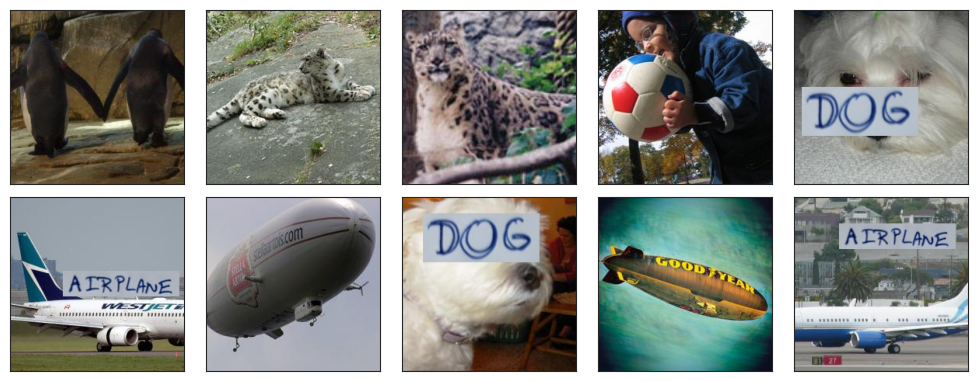

In [52]:
per_row = 5
to_show = 10
rows = int(np.ceil(float(to_show) / float(per_row)))

plt.figure(figsize = (2*per_row,2*rows),dpi=100)
for i in range(to_show):

  id_to_use = np.random.choice(range(len(x_test_unnormed)))
  img = x_test_unnormed[id_to_use]


  img_PIL = Image.fromarray(np.uint8(img))
  image = transform(img_PIL).unsqueeze(0).to(device)

  if True: #adding a sticker
    sticker_c = y_test[id_to_use]
    print(sticker_c)
    if class_names[sticker_c] in sticker_dict.keys():
      sticker_i = np.random.choice(range(len(sticker_dict[class_names[sticker_c]][0])))
      image_sticker = transform(Image.fromarray(np.uint8(sticker_dict[class_names[sticker_c]][0][sticker_i]))).unsqueeze(0).to(device)
      sticker_mask = torch.Tensor(sticker_dict[class_names[sticker_c]][1][sticker_i]).to(device)
      image = image_sticker*sticker_mask + image*(1-sticker_mask)
    else:
      print(f"no sticker for class {class_names[sticker_c]}")


  plt.subplot(rows,per_row,i+1)
  plt.imshow(reverse_clip_transform(image.detach()[0]))
  plt.xticks([],[])
  plt.yticks([],[])

plt.tight_layout()

plt.show()

# Encapsulating classification into wrapper

In [53]:
def classify_images(images_np, class_texts, skip_transform = False,verbose = True):

  text = clip.tokenize(class_texts).to(device)

  collecting_predictions_list = []
  collecting_ground_truth_list = []

  for i,img in enumerate(images_np):

    if verbose and (i % 50 == 0):
      print(i)


    if skip_transform == False:
      img_PIL = Image.fromarray(np.uint8(img))
      image = transform(img_PIL).unsqueeze(0).to(device)
    else:
      image = torch.Tensor(img).unsqueeze(0).to(device)

    with torch.no_grad():

      logits_from_image, logits_from_text = model(image, text)
      probs = logits_from_image.softmax(dim=-1).cpu().numpy()

      collecting_predictions_list.append(probs)
      collecting_ground_truth_list.append(y_test[i])

  return np.concatenate(collecting_predictions_list,axis=0)


In [54]:
subset_size = 100
preds_now = classify_images(x_test_unnormed[:subset_size], class_names)
acc_now = np.mean(np.argmax(preds_now,axis=-1) == y_test[:subset_size])
print("test subset accuracy = "+str(acc_now))

0
50
test subset accuracy = 0.99


# Plotting style

In [55]:
import matplotlib as mpl
import seaborn as sns
sns.set_style("ticks")

# mpl.style.use('seaborn-notebook')
mpl.rcParams.update({'font.size': 14, 'lines.linewidth': 2, 'figure.figsize': (6, 6/1.61)})
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['lines.markersize'] = 6
# mpl.rcParams['lines.marker'] = None
mpl.rcParams['axes.grid'] = True
COLORS = plt.rcParams["axes.prop_cycle"].by_key()["color"]

DEFAULT_FONTSIZE = 13
mpl.rcParams.update({'font.size': DEFAULT_FONTSIZE, 'lines.linewidth': 2,
                    'legend.fontsize': DEFAULT_FONTSIZE, 'axes.labelsize': DEFAULT_FONTSIZE,
                    'xtick.labelsize': DEFAULT_FONTSIZE, 'ytick.labelsize': DEFAULT_FONTSIZE, 'figure.figsize': (7, 7.0/1.4)})

markers_list = ["o","x","D","*","^"]


plt.rcParams['svg.fonttype'] = 'none'

# Wrapper for adversary finding

In [ ]:
# Completed: Preprocess + targeted attack helper
import torch
import torchvision.transforms as T
from PIL import Image

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def preprocess_image(image: Image.Image) -> torch.Tensor:
    """Convert PIL image to normalized tensor expected by ImageNet models."""
    tfm = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])
    return tfm(image)

def targeted_fgsm(x: torch.Tensor, target_label: int, model, eps: float = 4/255) -> torch.Tensor:
    """Create a targeted FGSM adversarial example that increases the log_prob of the target label."""
    x = x.clone().detach().requires_grad_(True)
    model.zero_grad(set_to_none=True)
    logits = model(x)
    loss = -torch.nn.functional.cross_entropy(logits, torch.tensor([target_label], device=x.device))
    loss.backward()
    adv = torch.clamp(x + eps * x.grad.sign(), -10, 10)
    return adv.detach()


# Class finding util

In [57]:
def get_different_class(cs_toexclude,classes = 10):
  classes_kept = [c for c in range(classes) if c not in cs_toexclude]
  return int(np.random.choice(classes_kept,()))

# Experiment 1: Original -> +sticker -> +adversarial perturbation

In [ ]:

N_adversaries = 2 #number of images to run


EPS = 32./255.
LR = .7*EPS
steps = 30

#collecting images and labels
collected_original_images_nosticker = []
collected_original_images = []
collected_original_labels = []
collected_sticker_labels = []
collected_modified_images = []
collected_modified_labels = []

print(device)

for j in range(N_adversaries):

  print("Image "+str(j+1)+"/"+str(N_adversaries))

  id_chosen = int(np.random.choice(range(len(x_test_unnormed)),()))

  true_label = y_test[id_chosen]
  target_label = get_different_class([int(true_label)])

  print("True label = "+str(true_label)+" target label = "+str(target_label))

  img_PIL = Image.fromarray(np.uint8(x_test_unnormed[id_chosen]))
  image = process_img(img_PIL).unsqueeze(0).to(device)

  collected_original_images_nosticker.append(normalize(image).detach().cpu().numpy())

  if True and (class_names[sticker_c] in sticker_dict.keys()): #adding a sticker
    sticker_c = get_different_class([int(true_label),int(target_label)])
    collected_sticker_labels.append(sticker_c)
    sticker_i = np.random.choice(range(len(sticker_dict[class_names[sticker_c]][0])))

    image_sticker = process_img(Image.fromarray(np.uint8(sticker_dict[class_names[sticker_c]][0][sticker_i]))).unsqueeze(0).to(device)
    sticker_mask = torch.Tensor(sticker_dict[class_names[sticker_c]][1][sticker_i]).to(device)
    image_sticker = image_sticker*sticker_mask + image*(1-sticker_mask)
  else: 
    print(class_names[sticker_c])
    image_sticker = image
    collected_sticker_labels.append(sticker_c)


  image_original_np = image_sticker.detach().cpu().numpy()

  collected_original_images.append(normalize(torch.tensor(image_original_np)).numpy())

  collected_original_labels.append(true_label)

  collected_modified_labels.append(target_label)

  image_np = get_adversary(model,image,target_label, LR=LR, steps=steps,epsilon=EPS).cpu().numpy()

  collected_modified_images.append(normalize(torch.tensor(image_np)).numpy())



cuda
Image 1/2
True label = 9 target label = 0
pingouin


Image 2/2
True label = 0 target label = 4
pingouin


## Predictions

In [169]:
original_preds_nosticker_now = classify_images(np.concatenate(collected_original_images_nosticker,axis=0), class_names, skip_transform=True, verbose=False)
original_preds_now = classify_images(np.concatenate(collected_original_images,axis=0), class_names, skip_transform=True, verbose=False)
modified_preds_now = classify_images(np.concatenate(collected_modified_images,axis=0), class_names, skip_transform=True, verbose=False)

## Plotting

In [170]:
def v2_make_plot_from_preds(orig_preds,class_labels,colors = ["forestgreen"]):

  width = 0.45

  for i in range(orig_preds.shape[0]):
    v_orig = orig_preds[i]
    alpha_orig = 0.6

    if np.argmax(orig_preds) == i:
      alpha_orig = 1.0

    plt.fill_between([0,v_orig],[i-width,i-width],[i+width,i+width], color = colors[0],alpha = alpha_orig)

  for i in range(len(class_labels)):
    text = class_labels[i]
    if orig_preds[i] > 0.3:
      text = text + " " + str(int(orig_preds[i]*100))+"%"
    plt.text(0,i-0.3,text,fontsize = 14)

  plt.xticks(fontsize = 14)
  plt.yticks([],[])

  plt.xlabel("Probability",fontsize = 16)
  plt.xlim([-0.015,1.0])


(224, 224, 3)


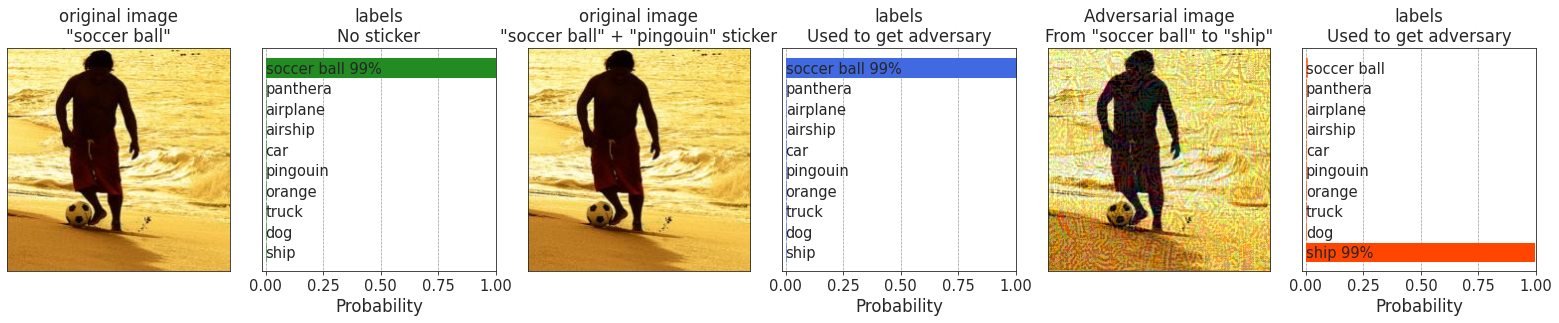

(224, 224, 3)


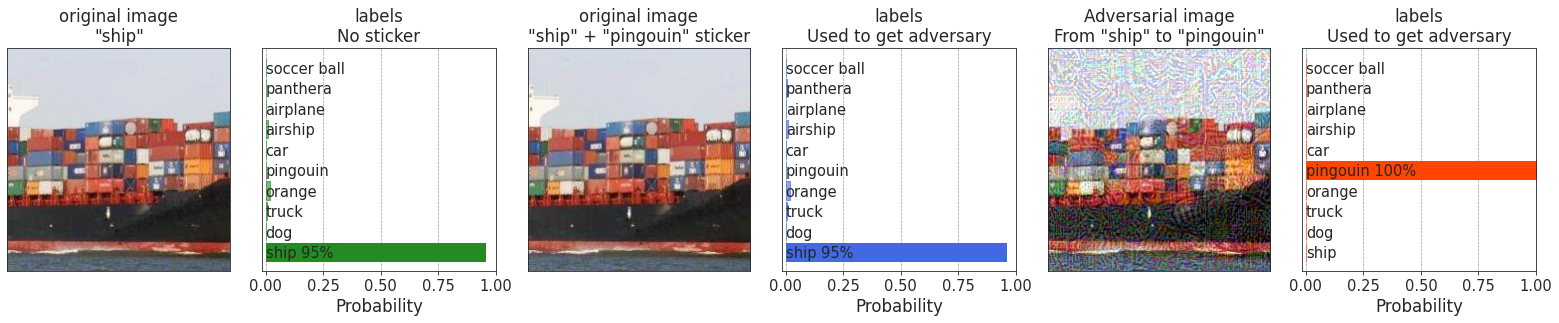

In [171]:
from matplotlib import cm
i = 0
for id_to_show in range(original_preds_now.shape[0]):
  i+=1
  plt.figure(figsize = (6*3.5,4.5),dpi = 75)

  plt.subplot(1,6,2)
  plt.title("labels\nNo sticker",fontsize = 16)
  v2_make_plot_from_preds(original_preds_nosticker_now[id_to_show],class_names,colors = ["forestgreen"])
  # plt.ylabel("Original dataset labels")

  plt.subplot(1,6,4)
  plt.title("labels\nUsed to get adversary",fontsize = 16)
  v2_make_plot_from_preds(original_preds_now[id_to_show],class_names,colors = ["royalblue"])
  # plt.ylabel("Original dataset labels")

  plt.subplot(1,6,6)
  plt.title("labels\nUsed to get adversary",fontsize = 16)
  v2_make_plot_from_preds(modified_preds_now[id_to_show],class_names,colors = ["orangered"])
  # plt.ylabel("Original dataset labels")

  plt.subplot(1,6,1)
  plt.title("original image\n\""+class_names[collected_original_labels[id_to_show]]+"\"",fontsize = 16)
  plt.imshow(reverse_clip_transform(collected_original_images_nosticker[id_to_show][0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(1,6,3)
  plt.title("original image\n\""+class_names[collected_original_labels[id_to_show]]+"\" + \""+class_names[collected_sticker_labels[id_to_show]]+"\" sticker",fontsize = 16)
  plt.imshow(reverse_clip_transform(collected_original_images[id_to_show][0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])

  plt.subplot(1,6,5)
  plt.title("Adversarial image\nFrom \""+class_names[collected_original_labels[id_to_show]]+"\" to \""+class_names[collected_modified_labels[id_to_show]]+"\"",fontsize = 16)
  plt.imshow(reverse_clip_transform(collected_modified_images[id_to_show][0]))
  plt.grid(False)
  plt.xticks([],[])
  plt.yticks([],[])
  print(reverse_clip_transform(collected_modified_images[id_to_show][0]).shape)
  im = Image.fromarray(np.uint8(reverse_clip_transform(collected_modified_images[id_to_show][0])*255))
  im.save(f"adv_{i}.png")


  plt.tight_layout()

  plt.show()

# Last Things to try

Compute more transferable attacks by:
- Taking the average loss over several (similar) prompt
- Taking the average loss over several data transformations
- Taking the average loss over several (diffrent) models outputs

Try to see if the attack transfers to ChatGPT (or any VLM)